In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

#itamargr_dfdc_faces_of_the_train_sample_path = kagglehub.dataset_download('itamargr/dfdc-faces-of-the-train-sample')
#manjilkarki_deepfake_and_real_images_path = kagglehub.dataset_download('manjilkarki/deepfake-and-real-images')
phoenixrose07_deepfake_path = kagglehub.dataset_download('phoenixrose07/deepfake')

print('Data source import complete.')


100%|██████████| 1.68G/1.68G [00:10<00:00, 169MB/s]

Extracting files...


Data source import complete.


In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#getting all the import statements
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import random
import time
import os
from collections import Counter
import pandas as pd
import numpy as np
import PIL
import timm

In [4]:
train_dir = "/root/.cache/kagglehub/datasets/phoenixrose07/deepfake/versions/1/Train"
val_dir = "/root/.cache/kagglehub/datasets/phoenixrose07/deepfake/versions/1/Validation"
test_dir = "/root/.cache/kagglehub/datasets/phoenixrose07/deepfake/versions/1/Test"

In [5]:
#augument the data when needed
#applying a simple transform
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop with size 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Horizontal flip with 50% probability
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomRotation(degrees=15),                # Random rotation up to ±15 degrees

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
# train_dataset = datasets.ImageFolder("/kaggle/input/dfdc-faces-of-the-train-sample/train", transform=transform)

# # Assuming 'dataset' is your original dataset and 'targets' contains the labels
# # For example, dataset.targets or dataset.labels should hold class labels
# targets = train_dataset.targets  # Update based on your dataset (e.g., dataset.labels)

# # Separate indices for each class
# class_0_indices = [i for i, label in enumerate(targets) if label == 0]
# class_1_indices = [i for i, label in enumerate(targets) if label == 1]

# # Sample 20,000 indices from class 0
# sampled_class_0_indices = random.sample(class_0_indices, 20000)

# # Combine all class 1 indices and sampled class 0 indices
# balanced_indices = sampled_class_0_indices + class_1_indices

# # Shuffle the indices
# random.shuffle(balanced_indices)

# # Create a subset dataset using the balanced indices
# balanced_dataset = Subset(train_dataset, balanced_indices)

# # Create a DataLoader with the balanced dataset
# train_dataloader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)

In [7]:
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [8]:
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
#class distribution in the train_dataset
print(f"Classes: {train_dataset.classes}")

Classes: ['Fake', 'Real']


In [10]:
LABELS = train_dataset.classes

In [11]:
#check distribution
train_classes = [train_dataset.targets[i] for i in range(len(train_dataset))]
print("Class distribution in training set:", Counter(train_classes))

Class distribution in training set: Counter({0: 70001, 1: 70001})


In [ ]:
# balanced_labels = [targets[i] for i in balanced_indices]
# print("Class distribution in balanced dataset:", Counter(balanced_labels))

In [ ]:
# train_dataloader=balanced_dataloader

Batch size: torch.Size([500, 3, 224, 224])


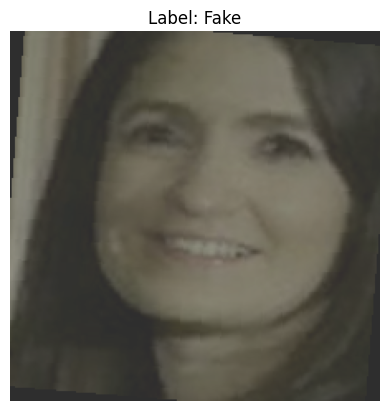

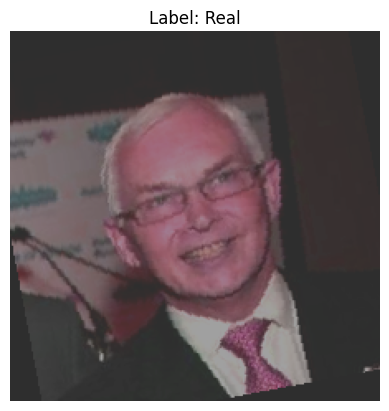

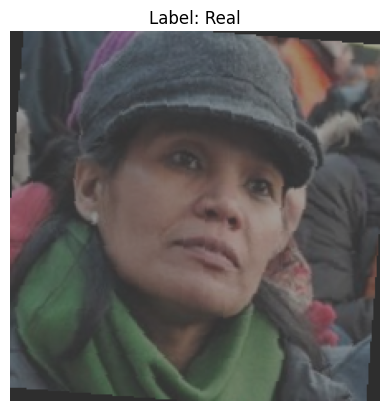

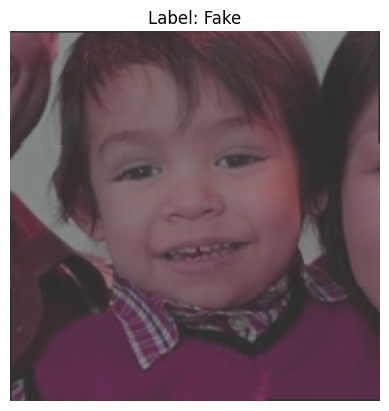

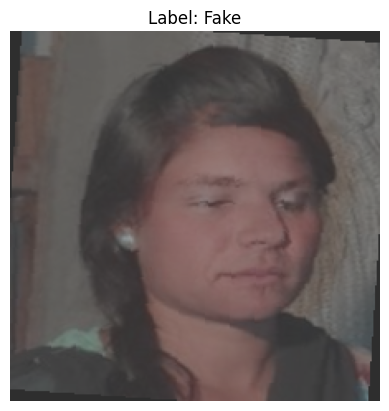

In [12]:
data_iter = iter(train_dataloader)
images, labels = next(data_iter)
print("Batch size:", images.shape)


#displaying the first 5 images
for i in range(5):
    #denormalization
    plt.imshow(images[i].permute(1, 2, 0).numpy() * 0.225 + 0.406)
    plt.title(f"Label: {LABELS[labels[i]]}")
    plt.axis("off")
    plt.show()

In [ ]:

class CNN(nn.Module):
    def __init__(self, num_classes=1):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # 3 input channels (RGB), 16 output
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16 channels, 112x112

            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1),  # Match input to output of previous layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64 channels, 56x56

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # Match input to output of previous layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128 channels, 28x28

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),  # Match input to output of previous layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 256 channels, 14x14

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),  # Match input to output of previous layer
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(7, 7))  # Fixed output size
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),  # Match input size from features
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
model_vit=CNN()

In [14]:
# Move model to GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vit = model_vit.to(device)
device

device(type='cuda')

In [15]:
criterion = nn.BCELoss()
#optimizer = Adam, with learning rate =0.001
optimizer = optim.Adam(model_vit.parameters(), lr=0.001)

In [16]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 5

for epoch in range(num_epochs):
    model_vit.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model_vit(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #For sigmoid: >0.5=1 else 0
        predicted = (outputs > 0.5).int()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_acc = 100 * correct_train / total_train
    train_accuracies.append(train_acc)

    #setting model_vit to validation phase
    model_vit.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    #witout computing gradients
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().view(-1, 1)
            outputs = model_vit(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs > 0.5).int()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/5, Train Loss: 0.4840, Train Acc: 74.66%, Val Loss: 0.5365, Val Acc: 75.37%
Epoch 2/5, Train Loss: 0.2101, Train Acc: 91.22%, Val Loss: 0.2289, Val Acc: 90.24%
Epoch 3/5, Train Loss: 0.1500, Train Acc: 93.99%, Val Loss: 0.2227, Val Acc: 91.33%
Epoch 4/5, Train Loss: 0.1258, Train Acc: 94.91%, Val Loss: 0.1704, Val Acc: 93.09%
Epoch 5/5, Train Loss: 0.1068, Train Acc: 95.74%, Val Loss: 0.1767, Val Acc: 92.88%


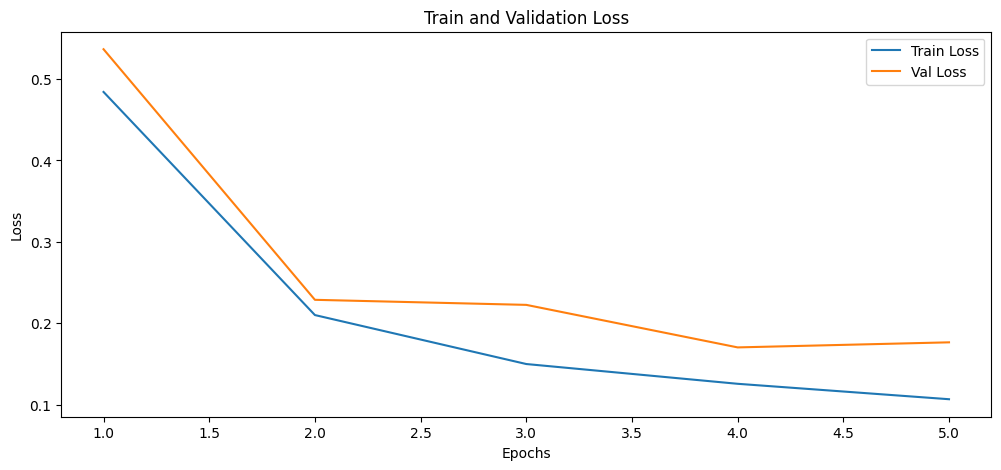

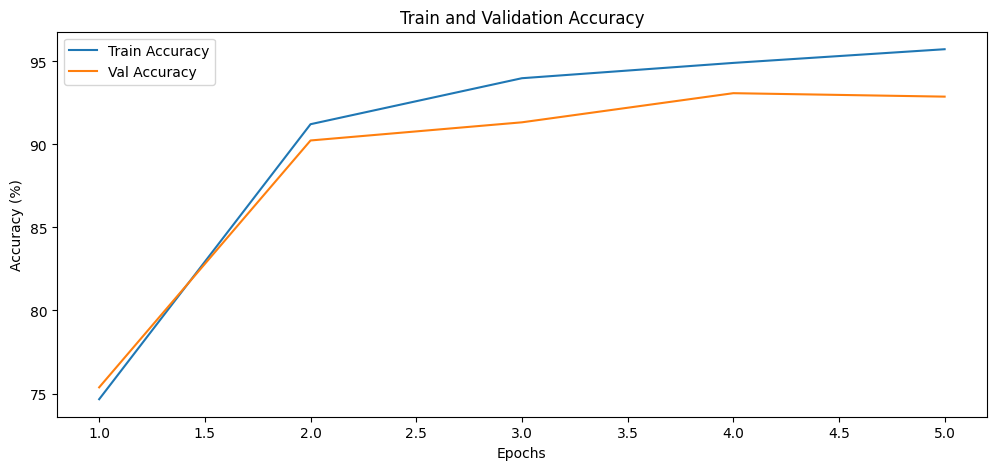

In [17]:
# Plot losses
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [18]:
torch.save(model_vit.state_dict(), "cnn__model.pth")

In [19]:
# Put the model_vit in evaluation mode
model_vit.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():  # No gradient computation for evaluation
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().view(-1, 1)  # Reshape for BCE loss
        outputs = model_vit(inputs)

        # Apply threshold to get binary predictions
        predicted = (outputs > 0.5).int()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


              precision    recall  f1-score   support

        Fake       0.90      0.92      0.91      5492
        Real       0.92      0.89      0.91      5413

    accuracy                           0.91     10905
   macro avg       0.91      0.91      0.91     10905
weighted avg       0.91      0.91      0.91     10905



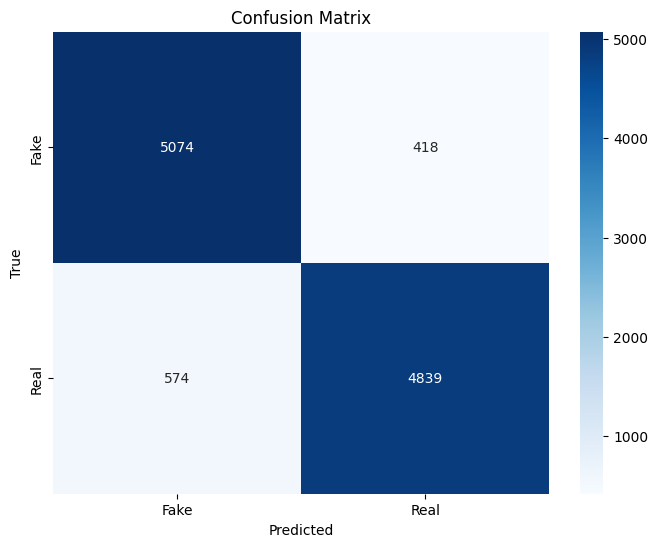

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
!pip install lime
import numpy as np
import torch
from torchvision import models, transforms
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=796bcd4bf2dd2b3bd205f88cb0c143ef350708aed4e6b95132eaaa34c125ffbf
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Loaded Image shape: (256, 256, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

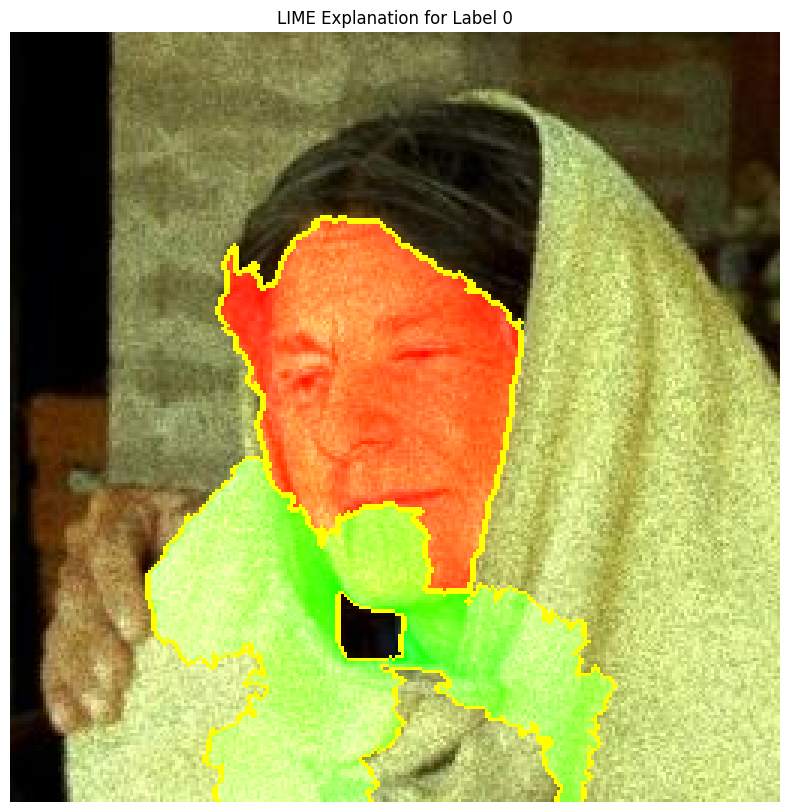

In [ ]:
from PIL import Image

model_vit.eval()


def preprocess_image(img):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(img)


def predict(images):
    inputs = torch.stack([preprocess_image(Image.fromarray(image)) for image in images]).to(device)
    with torch.no_grad():
        outputs = model_vit(inputs)
        probabilities = outputs.cpu().numpy()
    return probabilities


image_path = "/content/fake_0.jpg"
img = Image.open(image_path).convert("RGB")
img_np = np.array(img)

print("Loaded Image shape:", img_np.shape)

#Lime
explainer = LimeImageExplainer()

#explaination
explanation = explainer.explain_instance(
     img_np,
    predict,
    top_labels=1,
    num_features=1000,  # Try a higher number of features for better segmentation
    hide_color=0,
    batch_size=8   # Number of images to process in a batch
)

#top label explanation
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=False,
    num_features=10,
    hide_rest=False
)

#visualization
plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation for Label {top_label}")
plt.axis("off")
plt.show()